# Assignment 4: Transfer learning

The goal of this assignment is to demonstrate a technique called transfer learning. Transfer learning is a good way to quickly get good performance on the Patch-CAMELYON benchmark.

### Peliminaries

Transfer learning is a technique where instead of random initialization of the parameters of a model, we use a model that was pre-trained for a different task as the starting point. The two ways by which the pre-trained model can be transferred to the new task is by fine-tuning the complete model, or using it as a fixed feature extractor on top of which a new (usually linear) model is trained. For example, we can take a neural network model that was trained on the popular [ImageNet](http://www.image-net.org/) dataset that consists of images of objects (including categories such as "parachute" and "toaster") and apply it to cancer metastases detection.

This technique is explained in more detail in the following [video](https://www.youtube.com/watch?v=yofjFQddwHE) by Andrew Ng:


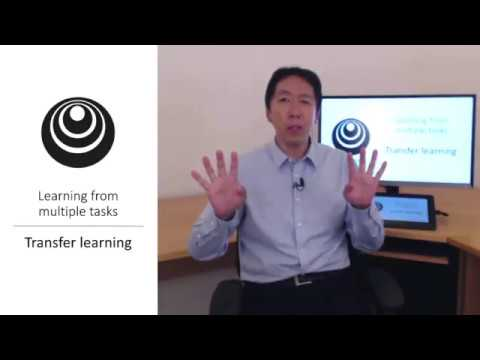

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('yofjFQddwHE')

If you are curious about different pre-training that you can use, you might want to have a look at [this paper]( https://arxiv.org/abs/1810.05444).


### Fine-tuning a pre-trained model

*Note that the code blocks below are only illustrative snippets from* `transfer.py` *and cannot be executed on their own within the notebook.*

An example of fine tuning a model is given in the `transfer.py` file. This example is very similar to the convolutional neural network example from the third assignments, so we will just highlight the differences.

The Keras library includes quite a few pre-trained models that can be used for transfer learning. The examples uses the MobileNetV2 model that is described in details [here](https://arxiv.org/abs/1801.04381). This architecture is targeted for use on mobile devices. We chose it for this example since it is "lightweight" and it can be relatively efficiently trained even on the CPU.

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In addition to the model, we also import the associated preprocessing function that is then used in the generator function instead of the rescale-only preprocessing used in the CNN example:

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

The code snippet below shows how to initialize the MobileNetV2 model for fine-tuning on the Patch-CAMELYON dataset. Compared to the previous examples that used the Keras Sequential API, this example uses the Keras Functional API.

In [ ]:
input = Input(input_shape)

# get the pretrained model, cut out the top layer
pretrained = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# if the pretrained model it to be used as a feature extractor, and not for
# fine-tuning, the weights of the model can be frozen in the following way
# for layer in pretrained.layers:
#    layer.trainable = False

output = pretrained(input)
output = GlobalAveragePooling2D()(output)
output = Dropout(0.5)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(input, output)

# note the lower lr compared to the cnn example
model.compile(SGD(learning_rate=0.001, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])

The architecture of the model is given below. The MobileNetV2 model takes the 96x96x3 images from the Patch-CAMELYON dataset and produces 1280 feature maps of size 3x3. The feature maps are then pooled and connected to the output layer of the model (with a dropout layer in between; see Exercise 3).

In [ ]:
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #
# =================================================================
# input_1 (InputLayer)         (None, 96, 96, 3)         0
# _________________________________________________________________
# mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984
# _________________________________________________________________
# global_average_pooling2d_1 ( (None, 1280)              0
# _________________________________________________________________
# dropout_1 (Dropout)          (None, 1280)              0
# _________________________________________________________________
# dense_1 (Dense)              (None, 1)                 1281
# =================================================================
# Total params: 2,259,265
# Trainable params: 2,225,153
# Non-trainable params: 34,112

The remainder of the code in `transfer.py` performs training (i.e. fine-tuning) of the model in much the same way as in the CNN example. One difference is that instead of training for a number of full epochs, we define "mini-epochs" that contain around 5% of the training and validation samples. Since the fine-tuning of the model converges fast (you can expect convergence in less than one epoch), this will provide more fine-grained feedback about the performance on the validation set. 

## Exercise 1

When does transfer learning make sense? Hint: watch the video. Does it make sense to do transfer learning from ImageNet to the Patch-CAMELYON dataset?


## Exercise 2

Run the example in `transfer.py`. Then, modify the code so that the MobileNetV2 model is not initialized from the ImageNet weights, but randomly (you can do that by setting the `weights` parameter to `None`). Analyze the results from both runs and compare them to the CNN example in assignment 3.

## Exercise 3

The model in `transfer.py` uses a dropout layer. How does dropout work and what is the effect of adding dropout layers the the network architecture? What is the observed effect when removing the dropout layer from this model? Hint: check out the Keras documentation for this layer.

## Submission checklist

- Exercise 1: Answers to the questions
- Exercise 2: Answers to the questions and code
- Exercise 3: Answers to the questions

### Before you start working on the main project...

As mentioned before, transfer learning is a good way to quickly get good performance on the Patch-CAMELYON benchmark. Note, however, that this is not the objectives of the course. One of the main objectives is for the students to get "insight in setting up a research question that can be quantitatively investigated". While it would certainly be nice to score high on the challenge leaderboard, it is much more important to ask a good research question and properly investigate it. You are free to choose what you want to investigate and the course instructors can give you feedback.

# Answers exercise 1
Transfer learning can be used when you want to train a neural network for a certain task B but do not have a lot of data available for this task. However, you do have another task A for which you have more data and from which the low level features can be useful for learning task B. It is important that task A and task B have the same input. It does not make sense to pre-train a neural network on a database that is significantly smaller than the database for the task you want the model to perform. You can train a model for task B by taking a 'pre-trained' model that has been trained for task A, replace the output layer by randomly initialized weights and then finetune the weights of the layers. ImageNet has 1.2 million images, whereas Patch-CAMELYON has 327.680. ImageNet has a significantly larger image database. Therefore it makes sense to do transfer learning from ImageNet to the Patch-CAMELYON dataset. However, due to the large differences between the ImageNet and the Patch-CAMELYON datasets it is important that not only the output layer is replaced, but that the weights of a number of hidden layers are finetuned as well.

# Answers exercise 2
In this exercise, three models are compared. The first one is a transfer model (model 1) where the model weights are initialized using the ImageNet weights. In other words, pre-training of the model on ImageNet is performed. The second model (model 2) is a model with random initialization. The third model (model 3) is a convolutional neural network model. This model consists of two convolutional layers that are each followed by a max pooling layer, and finally by a fully connected layer with 64 neurons. A kernel size of 3x3 is used for the convolutional layer, and a pool size of 4x4 for the max pooling layer.
The layers in all models use ReLu activaiton, with exception of the output layers. For the output layers, sigmoid activation is used.

For the evaluation of the model performance, the validation and training accuracy were considered. This was done since the used dataset did not contain a labelled test set.

When looking at the training set, the accuracy was highest for model 1 (0.9158), followed by model 3 (0.8477) and model 2 (0.8393). When looking at the validation set, the accuracy was highest for model 3 (0.86), followed by model 1 (0.6913) and model 2 (0.5163). 

Since the validation dataset was not used for training of the model but only for model selection, the validation accuracy can be seen as the best metric to evaluate model performance in the absence of test accuracy. From the validation accuracy, we can conclude that the convolutional neural network model performs much better than the transfer model and the randomly initialized model. Moreover, the transfer model has higher performance that the model with randomly initialized weights.

Looking at the accuracy plot, it seems to be the case that model 1 has overtrained on the training set. The validation accuracy is highest after 6 epochs (0.865) and then decreases to 0.6913 after 9 epochs. Furthermore, the validation accuracy of model 3 does not increase. It's final value (0.5163) is actually lower than it's starting value (0.535).

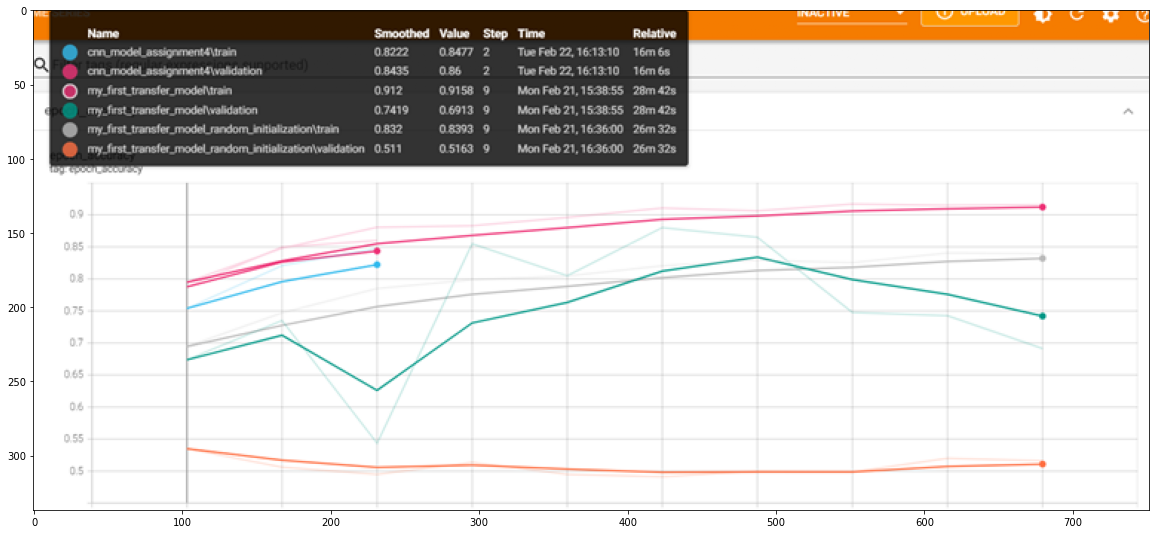

In [1]:
import matplotlib.pyplot as plt
LossPlotModel_1 = plt.imread(r"C:\Users\20191974\OneDrive - TU Eindhoven\Desktop\Year 3\Q3\8P361!\BIA-group-1\8p361-project-imaging-master\code\epoch_accuracy_ass4_ex2.png")
fig=plt.figure()
fig.set_size_inches(20,11) #Make sure the images are well visible
plt.imshow(LossPlotModel_1)

# Answers exercise 3
The Dropout layer sets input units to 0 randomly. The inputs that are not set to 0, are scaled up so that the sum over all inputs is unchanged. Adding a Dropout layer to the neural network helps prevents overfitting [1]. However, applying dropout to a neural network typically increases the training time [2]. 

When running transfer.py without the dropout layer, the computational time was 29 minutes and 12 seconds. While the computational time with dropout layer was 19 minutes and 16 seconds. This contradiction with the literature stated earlier can be a result of running additional other programs while running spyder during the training of the model without the dropout layer than during the training of the model with dropout layer.

The accuracies of the training set with dropout layer and without dropout layer are 0.9139 and 0.9206 respectively. The accuracies of the validation set with dropout layer and without dropout layer are 0.8575 and 0.7936. To conclude, the dropout layer in these models does not affect the accuracy of the training set significantly. However, it does affect the accuracy of the validation set, since this is significantly higher for the model with dropout layer than for the model without dropout layer. This corresponds to the found literature that the dropout layer helps with preventing overfitting.


[1] https://keras.io/api/layers/regularization_layers/dropout/
[2] https://ieeexplore.ieee.org/document/8122736



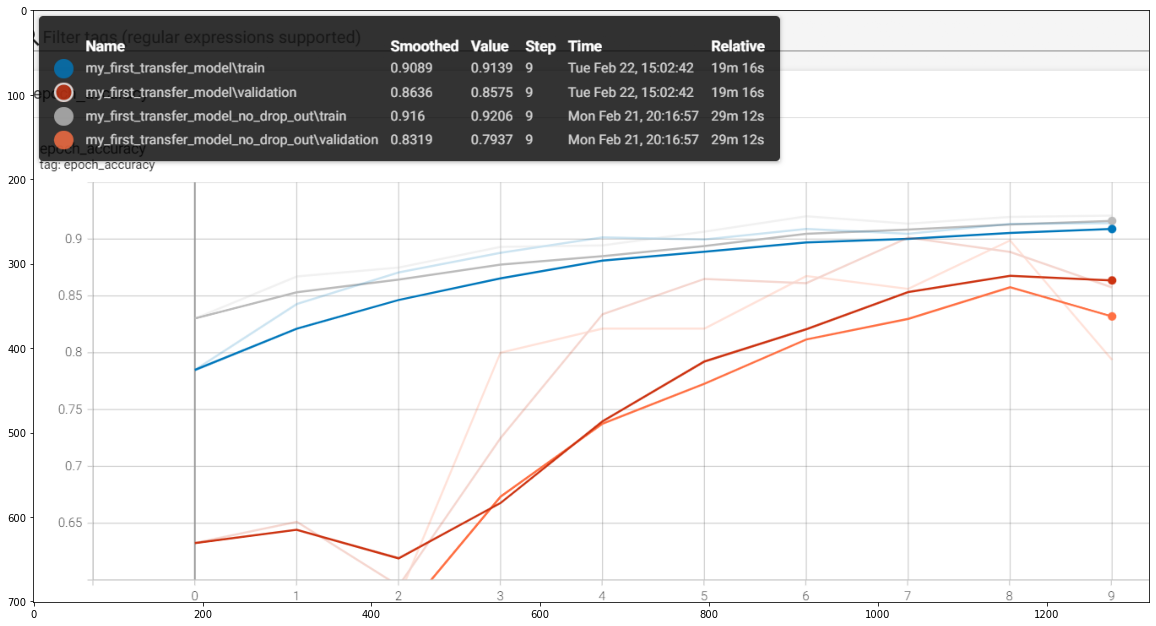

In [4]:
import matplotlib.pyplot as plt
LossPlotModel_1 = plt.imread(r"C:\Users\20191819\Documents\school\2021,2022\Q3\ProjectBIA\BIA-group-1\8p361-project-imaging-master\code\epoch_accuracy_ass4_ex3.png")
fig=plt.figure()
fig.set_size_inches(20,11) #Make sure the images are well visible
plt.imshow(LossPlotModel_1)